# Exercise 4: Yule-Simon distribution

In this exercise we will look at the Yule-Simon and how to generate it using an Agent Based Model (ABM) implemented in Python using the `mesa` library.

The process to generate a Yule-Simon distribution describing firm sizes is as follows:

1. Start with a single firm of size 1.
2. At each time step, a new agent enters the market.
3. The agent may either decide to start a new firm with probability $p$ or join an existing firm with probability $1-p$ and then choose a firm to join with probability proportional to the size of the firm.



## Section 1: Read the "Introduction to Mesa" notebook

Before attempting this exercise, have a look at the companion Notebook "Introduction to Mesa" to get familiar with the library.

## Section 2: Implement the Yule-Simon model

Specifically implement the following three classes:

1. `Firm`: This class represent a firm. Its most important attribute is size.

2. `NewAgent`: This class represent a new agent entering the market.

3. `World`: This class should represent the world.

In [27]:
import mesa
import numpy as np
from math import floor

In [28]:


class Firm(mesa.Agent):
    """A firm that can hire employees."""

    def __init__(self, unique_id: int, model: "World", first_employee: "NewAgent"):
        super().__init__(unique_id, model)
        self.employees: list[mesa.Agent] = [first_employee]
        self.size = 1  # Start with a size of 1

    def hire(self, agent: "NewAgent"):
        """Hire a new employee.
        
        Tasks:
        1. Append the 'agent' to the 'self.employees' list.
        2. Increase 'self.size' by 1.
        3. Set the 'agent.employer' to 'self'.
        """
        # your code here
        self.employees.append(agent)
        self.size+=1
        agent.employer = self


class NewAgent(mesa.Agent):
    """An agent that can either found a new firm or join an existing one."""

    def __init__(self, unique_id: int, model: "World"):
        super().__init__(unique_id, model)
        self.employer: Firm | None = None  # Initially, the agent doesn't have an employer

    def create_firm(self):
        """Found a new firm with the agent as the first employee.
        
        Use the 'create_firm' method from the 'World' model.
        """
        # your code here
        self.model.create_firm(self.model)


    def join_firm(self, firm: Firm):
        """Join an existing firm.
        
        Use the 'hire' method from the 'Firm' class.
        """
        # your code here
        firm.hire(self)

    def step(self):
        """Define the agent's actions per step.
        
        Each step, the agent decides based on a probability (start_up_prob) whether to found a new firm 
        or join an existing one. Use the 'create_firm' method for founding a new firm and 'join_firm' 
        for joining an existing firm. Both methods are part of this class; 'sample_firm' is found in the 'World' class.
        """
        # your code here
        prob = np.random.uniform(low=0, high=1)
        if prob<=self.model.start_up_prob:
            self.create_firm()
        else:
            # total_sizes = sum([firm.size for firm in self.model.firms])
            # firm_prob = np.random.uniform(low=0, high=total_sizes)
            # firm_to_join = self.model.firms[floor(firm_prob/len(self.model.firms))]

            self.join_firm(self.model.sample_firm())


## THIS CODE IS PROVIDED. YOU may want to adapt it for Section 3
class World(mesa.Model):
    """The model representing the world containing firms and agents."""

    def __init__(self, initial_agents=10, start_up_prob=0.1, collect_every=-1):
        super().__init__()
        self.start_up_prob = start_up_prob  # Probability of starting a new firm
        self.firms = []  # List of firms
        self.collect_every = collect_every

        self.schedule = mesa.time.BaseScheduler(self)
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters={"Firm sizes": self.collect_firm_sizes}
        )

        # Initialize agents
        for i in range(initial_agents):
            agent = NewAgent(i, self)
            self.schedule.add(agent)  # Important: add agents to the schedule

        # Ensure at least one firm exists at the start
        self.create_firm(first_employee=self.schedule.agents[0])

    def create_firm(self, first_employee: NewAgent):
        """Create a new firm."""
        next_id = len(self.firms)
        firm = Firm(next_id, self, first_employee)
        self.firms.append(firm)

    def sample_firm(self):
        """Sample a firm proportionally to its size."""
        firm_sizes = [firm.size for firm in self.firms]
        total_size = sum(firm_sizes)
        probabilities = [size / total_size for size in firm_sizes]
        return self.random.choices(self.firms, weights=probabilities)[0]

    def full_employment(self):
        """Check if all agents are employed."""
        return all(agent.employer is not None for agent in self.schedule.agents)
    
    def collect_firm_sizes(self):
        """Collect the sizes of all firms."""
        return [firm.size for firm in self.firms]

    def step(self):
        """Advance the model by one step, activating only one agent."""
        if len(self.schedule.agents) > 0:
            # Select a random agent to activate
            agent_to_activate = self.random.choice(self.schedule.agents)
            agent_to_activate.step()

            # Remove the agent after its step; it should not be activated again
            self.schedule.remove(agent_to_activate)
            
            if self.collect_every == -1 and self.full_employment(): # collect only at the end
                self.datacollector.collect(self)
            elif self.collect_every >= 1 and self.schedule.steps % self.collect_every == 0:
                self.datacollector.collect(self)

            # End the simulation if all agents are employed
            if self.full_employment():
                self.running = False

### Run and plot the firm size distribution

In [29]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 0, 'Firm size')

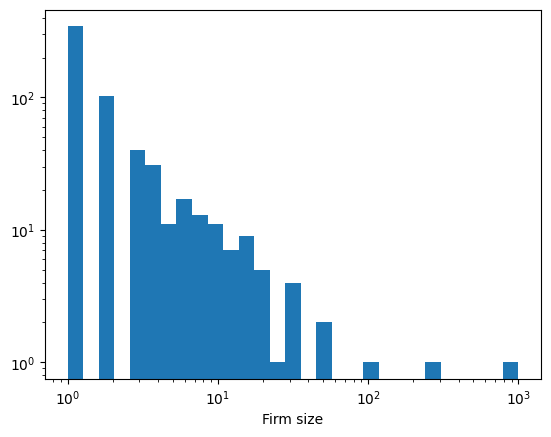

In [31]:
firm_model = World(3_000, start_up_prob=0.2)
firm_model.run_model()

firm_sizes = firm_model.datacollector.get_model_vars_dataframe()["Firm sizes"].values

plt.hist(firm_sizes, bins=np.logspace(0, 3, 30))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Firm size")

## Section 3: Extend the model

Change some aspect of the model and see how the size distribution changes. For example, you could have Agents quitting if the the firm size is above a certain threshold. Or you could have the probability of starting a new firm depend on the size of the largest firm. Or you could introduce mergers between firms.